# DBSCAN Debugging

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

agg = pd.read_csv('../data/outputs/agg_features.csv')

The following plot helps choose a good `eps` value by examining the distance to the 4th nearest neighbour.

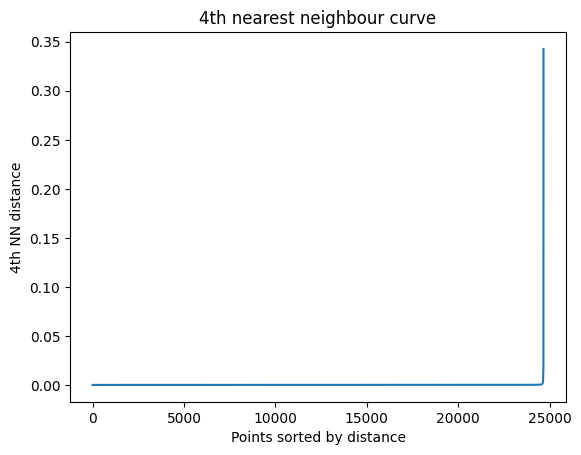

In [35]:
sim_cols = [c for c in agg.columns if c not in {'record_id','cluster'}]
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(agg[sim_cols])
# Distances to the 4th nearest neighbour for each point
dists, _ = neigh.kneighbors(agg[sim_cols])
fourth = dists[:, -1]
plt.plot(sorted(fourth))
plt.xlabel('Points sorted by distance')
plt.ylabel('4th NN distance')
plt.title('4th nearest neighbour curve')
plt.show()

Automatically detected optimal eps value: 0.0076
Knee point located at index: 24651


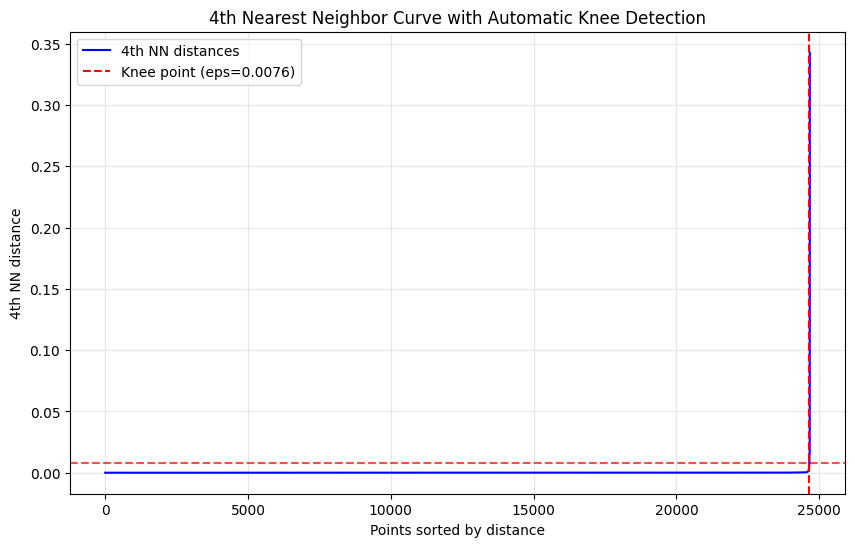

In [36]:
# Automatic knee detection for optimal eps value
try:
    from kneed import KneeLocator
    
    # Sort the distances for knee detection
    sorted_distances = sorted(fourth)
    x_values = range(len(sorted_distances))
    
    # Find the knee point
    knee_locator = KneeLocator(
        x_values, sorted_distances, 
        curve='convex', direction='increasing'
    )
    
    knee_point = knee_locator.knee
    if knee_point is not None:
        optimal_eps = sorted_distances[knee_point]
        print(f"Automatically detected optimal eps value: {optimal_eps:.4f}")
        print(f"Knee point located at index: {knee_point}")
        
        # Plot with knee point highlighted
        plt.figure(figsize=(10, 6))
        plt.plot(x_values, sorted_distances, 'b-', label='4th NN distances')
        plt.axvline(x=knee_point, color='r', linestyle='--', 
                   label=f'Knee point (eps={optimal_eps:.4f})')
        plt.axhline(y=optimal_eps, color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Points sorted by distance')
        plt.ylabel('4th NN distance')
        plt.title('4th Nearest Neighbor Curve with Automatic Knee Detection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No clear knee point detected. Consider manual inspection.")
        
except ImportError:
    print("kneed library not installed. Install with: pip install kneed")
    print("Falling back to manual inspection of the curve above.")

Use a knee in the curve above to set `eps`.

Suggested optimal eps value: 0.0076
Knee point found at index: 24651


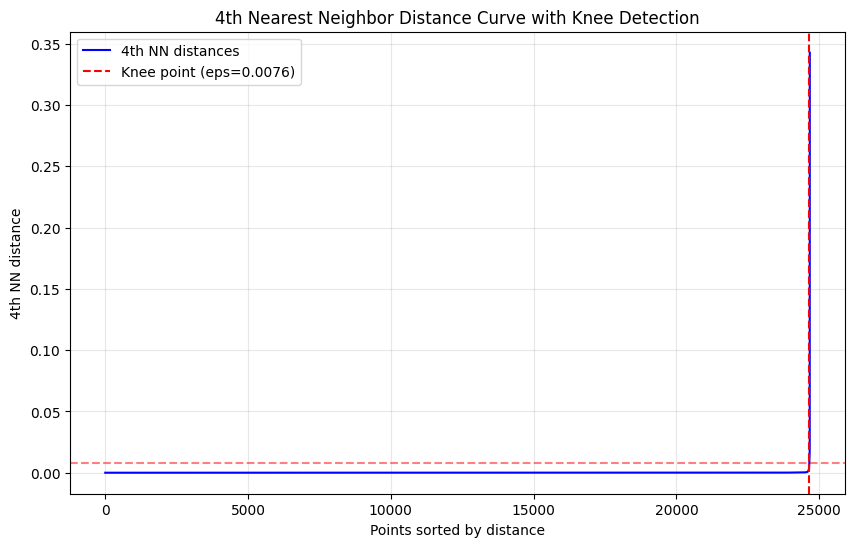

In [37]:
# Automatic knee detection for optimal eps
from kneed import KneeLocator
import numpy as np

# Sort the distances
sorted_distances = sorted(fourth)
x = range(len(sorted_distances))

# Find the knee point
knee_locator = KneeLocator(x, sorted_distances, curve='convex', direction='increasing')
knee_point = knee_locator.knee

if knee_point is not None:
    optimal_eps = sorted_distances[knee_point]
    print(f"Suggested optimal eps value: {optimal_eps:.4f}")
    print(f"Knee point found at index: {knee_point}")
    
    # Plot with knee point highlighted
    plt.figure(figsize=(10, 6))
    plt.plot(x, sorted_distances, 'b-', label='4th NN distances')
    if knee_point is not None:
        plt.axvline(x=knee_point, color='r', linestyle='--', label=f'Knee point (eps={optimal_eps:.4f})')
        plt.axhline(y=optimal_eps, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Points sorted by distance')
    plt.ylabel('4th NN distance')
    plt.title('4th Nearest Neighbor Distance Curve with Knee Detection')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No clear knee point detected. Consider manual inspection or try different parameters.")
    optimal_eps = np.median(sorted_distances)
    print(f"Using median distance as fallback eps: {optimal_eps:.4f}")

## Enhanced Parameter Suggestion

The following cell provides suggestions for both `eps` and `min_samples` by testing multiple combinations and evaluating cluster quality.

In [ ]:
# Enhanced parameter suggestion for both eps and min_samples
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def suggest_dbscan_parameters(X, eps_candidates=None, min_samples_range=range(2, 8)):
    """
    Suggest optimal DBSCAN parameters using multiple methods
    """
    if eps_candidates is None:
        # Use knee detection for eps
        neigh_suggest = NearestNeighbors(n_neighbors=4)
        neigh_suggest.fit(X)
        distances, _ = neigh_suggest.kneighbors(X)
        fourth_distances = distances[:, -1]
        sorted_distances = sorted(fourth_distances)
        
        # Find knee point
        knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, 
                                  curve='convex', direction='increasing')
        
        if knee_locator.knee is not None:
            optimal_eps = sorted_distances[knee_locator.knee]
            # Test around the knee point
            eps_candidates = [optimal_eps * 0.5, optimal_eps * 0.75, optimal_eps, 
                            optimal_eps * 1.25, optimal_eps * 1.5]
        else:
            # Fallback: use percentiles of distances
            eps_candidates = [np.percentile(sorted_distances, p) for p in [70, 80, 85, 90, 95]]
    
    print("🔍 Testing parameter combinations...")
    results = []
    
    for eps in eps_candidates:
        for min_samples in min_samples_range:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X)
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                noise_ratio = n_noise / len(X)
                
                # Only calculate silhouette for valid clusterings
                if n_clusters > 1 and n_clusters < len(X) * 0.9:
                    try:
                        silhouette = silhouette_score(X, labels)
                    except:
                        silhouette = -1
                else:
                    silhouette = -1
                
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'noise_ratio': noise_ratio,
                    'silhouette_score': silhouette
                })
                
            except Exception as e:
                continue
    
    # Convert to DataFrame for easy analysis
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        # Filter for reasonable results
        reasonable = results_df[
            (results_df['n_clusters'] >= 2) & 
            (results_df['n_clusters'] <= len(X) * 0.1) &  # Not too many clusters
            (results_df['noise_ratio'] <= 0.5) &  # Not too much noise
            (results_df['silhouette_score'] > 0)
        ]
        
        if len(reasonable) > 0:
            # Find best combination
            best_idx = reasonable['silhouette_score'].idxmax()
            best_params = reasonable.loc[best_idx]
            
            print(f"🎯 Suggested Parameters:")
            print(f"  • eps: {best_params['eps']:.4f}")
            print(f"  • min_samples: {best_params['min_samples']}")
            print(f"  • Expected clusters: {best_params['n_clusters']}")
            print(f"  • Noise ratio: {best_params['noise_ratio']:.1%}")
            print(f"  • Silhouette score: {best_params['silhouette_score']:.3f}")
            
            # Show top 3 alternatives
            top_3 = reasonable.nlargest(3, 'silhouette_score')
            print(f"\n📊 Top 3 Parameter Combinations:")
            for i, (_, row) in enumerate(top_3.iterrows(), 1):
                print(f"{i}. eps={row['eps']:.4f}, min_samples={row['min_samples']}, "
                      f"clusters={row['n_clusters']}, silhouette={row['silhouette_score']:.3f}")
            
            return best_params['eps'], best_params['min_samples'], results_df
        else:
            print("⚠️ No reasonable parameter combinations found. Try adjusting the ranges.")
            return None, None, results_df
    else:
        print("❌ No valid results found.")
        return None, None, None

# Run the enhanced parameter suggestion
suggested_eps, suggested_min_samples, all_results = suggest_dbscan_parameters(agg[sim_cols])

# Store the suggestions for easy copy-paste
if suggested_eps is not None and suggested_min_samples is not None:
    print(f"\n💻 CLI Command:")
    print(f"python -m src.clustering --eps {suggested_eps:.4f} --min-samples {suggested_min_samples} --scale")

🔍 Testing parameter combinations...


In [ ]:
# Visualize parameter exploration results
if all_results is not None and len(all_results) > 0:
    try:
        import seaborn as sns
        
        # Create heatmap of silhouette scores
        pivot_table = all_results.pivot_table(
            values='silhouette_score', 
            index='min_samples', 
            columns='eps', 
            aggfunc='mean'
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Subplot 1: Silhouette score heatmap
        sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', ax=axes[0])
        axes[0].set_title('Silhouette Scores by Parameters')
        axes[0].set_xlabel('eps')
        axes[0].set_ylabel('min_samples')
        
        # Subplot 2: Number of clusters
        pivot_clusters = all_results.pivot_table(
            values='n_clusters', 
            index='min_samples', 
            columns='eps', 
            aggfunc='mean'
        )
        sns.heatmap(pivot_clusters, annot=True, fmt='.0f', cmap='plasma', ax=axes[1])
        axes[1].set_title('Number of Clusters by Parameters')
        axes[1].set_xlabel('eps')
        axes[1].set_ylabel('min_samples')
        
        plt.tight_layout()
        plt.show()
        
        # Show scatter plot of results
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(all_results['eps'], all_results['min_samples'], 
                            c=all_results['silhouette_score'], s=all_results['n_clusters']*10,
                            cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Silhouette Score')
        plt.xlabel('eps')
        plt.ylabel('min_samples')
        plt.title('Parameter Space (size = cluster count)')
        
        plt.subplot(1, 2, 2)
        plt.scatter(all_results['n_clusters'], all_results['silhouette_score'], 
                   c=all_results['noise_ratio'], alpha=0.7, cmap='Reds')
        plt.colorbar(label='Noise Ratio')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Clusters vs Quality (color = noise)')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Seaborn not available for advanced plotting. Install with: pip install seaborn")
        
        # Simple matplotlib visualization
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(all_results['eps'], all_results['min_samples'], 
                            c=all_results['silhouette_score'], s=60, alpha=0.7)
        plt.colorbar(scatter, label='Silhouette Score')
        plt.xlabel('eps')
        plt.ylabel('min_samples')
        plt.title('Parameter Exploration Results')
        plt.show()
else:
    print("No results to visualize.")

In [ ]:
n_features = len(sim_cols)
n_components = min(2, n_features)
pca = PCA(n_components=n_components)
X = pca.fit_transform(agg[sim_cols])

plt.figure()
if n_components == 2:
    if 'cluster' in agg.columns:
        plt.scatter(X[:,0], X[:,1], c=agg['cluster'], cmap='tab10', s=20)
    else:
        plt.scatter(X[:,0], X[:,1], s=20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
else:
    if 'cluster' in agg.columns:
        plt.scatter(X[:,0], [0]*len(X), c=agg['cluster'], cmap='tab10', s=20)
    else:
        plt.scatter(X[:,0], [0]*len(X), s=20)
    plt.xlabel('PC1')
    plt.ylabel('')
plt.title('PCA of aggregated features')
plt.show()

If cluster labels are provided, the scatter plot is coloured accordingly to inspect separability.

In [ ]:
agg['cluster'].value_counts()


Display the number of records in each cluster to identify large or potentially problematic clusters.

In [ ]:
big = agg[agg['cluster'] == 0]           # or whichever label is huge
big.head(20)                             # see company/domain/phone fields


Inspect the records in the largest (or a selected) cluster to review company, domain, and phone fields for further analysis or manual investigation.